<h1>우동 악플 분류 모델</h1>

In [ ]:
!pip install konlpy

In [ ]:
import os
from gensim.models.word2vec import Word2Vec
import pandas as pd
import jpype
from konlpy.tag import Kkma
import numpy as np
kkma = Kkma()

In [ ]:
!pip install datasets

In [ ]:
from datasets import load_dataset
raw_dataset = load_dataset("kor_hate")

In [ ]:
#only for hate, 0:악플, 1:공격적, 2:해당없음
train_texts = raw_dataset['train']['comments']
train_labels= raw_dataset['train']['hate']
test_texts = raw_dataset['test']['comments']
test_labels = raw_dataset['test']['hate']

In [ ]:
print('학습 데이터셋 개수 :', len(train_texts))
print('테스트 데이터셋 개수 :', len(test_texts))


학습 데이터셋 개수 : 7896
테스트 데이터셋 개수 : 471


<h2> w2v모델 제작 </h2>

In [ ]:
#kkma 품사 태그표
#http://kkma.snu.ac.kr/documents/index.jsp?doc=postag

In [ ]:
#토크나이저
'''def tokenizer_kkma(doc):
  jpype.attachThreadToJVM()
  token_doc = [word[0] for word in kkma.pos(doc) if word[1] not in stopwords]
  return token_doc
'''
def tokenizer_kkma(doc):
  jpype.attachThreadToJVM()
  token_doc = [word[0] for word in kkma.pos(doc) if word[1] in kkma_pos]
  return token_doc
#stopwords = ['SS', 'SW', 'SE', 'SP'] 오리지널
#stopwords = ['SS', 'SW', 'SE', 'SP' , 'ETD', 'EPT', 'EFN', 'UN'] #UPGRADEV1
#stopwords = ['SS', 'SW', 'SE', 'SP', 'SF', 'ETD', 'EPT', 'EFN', 'UN', 'NR', 'JX', 'ETN', 'VCP', 'JKS', 'EFQ', 'NNM'] #UPGRADEV2
kkma_pos = ['NNP', 'NNG', 'OL', 'NP','VV', 'VA' ]#UPGRADEV3 핵심만 사용

def tokenized_all(doc):
  tok_list = []
  for i in doc:
    tokenized_text = tokenizer_kkma(i)
    tok_list.append(tokenized_text)
  return tok_list

In [ ]:
a = [word[0] for word in kkma.pos(raw_dataset['train']['comments'][2]) if word[1] not in stopwords]
b = [word[0] for word in kkma.pos(raw_dataset['train']['comments'][2]) if word[1] in kkma_pos]
print(a)
print(b)

['못되', '넘', '드', '남', '의', '고통', '을', '즐기', '넘', '드', '이젠', '마땅', '하', '처벌', '을', '받', '그리하', '여야', '공정', '하', '사회', '지', '심', '대', '로', '거두', '거']
['못되', '드', '남', '고통', '즐기', '드', '이젠', '처벌', '받', '그리하', '공정', '사회', '지', '심', '대', '거두']


In [ ]:
kkma.pos(raw_dataset['train']['comments'][9])

[('10', 'NR'),
 ('년', 'NNM'),
 ('차', 'NNG'),
 ('방탄', 'NNG'),
 ('팬', 'NNG'),
 ('이', 'VCP'),
 ('ㄴ데', 'ECE'),
 ('우리', 'NP'),
 ('방탄', 'NNG'),
 ('처럼', 'JKM'),
 ('성공', 'NNG'),
 ('은', 'JX'),
 ('못하', 'VX'),
 ('겠', 'EPT'),
 ('지만', 'ECE'),
 ('일단', 'MAG'),
 ('방탄', 'NNG'),
 ('의', 'JKG'),
 ('부하', 'NNG'),
 ('가', 'JKC'),
 ('되', 'VV'),
 ('고', 'ECE'),
 ('싶', 'VXA'),
 ('다는', 'ETD'),
 ('거', 'NNB'),
 ('니', 'JC'),
 ('이름', 'NNG'),
 ('기억', 'NNG'),
 ('은', 'JX'),
 ('하', 'VV'),
 ('어', 'ECS'),
 ('두', 'VXV'),
 ('ㅁ', 'ETN'),
 ('ㅇ', 'NNG'),
 ('ㅇ', 'NNG')]

In [ ]:
tokenizer_kkma(raw_dataset['train']['comments'][2])

['못되',
 '드',
 '남',
 '고통',
 '즐기',
 '드',
 '이젠',
 '처벌',
 '받',
 '그리하',
 '공정',
 '사회',
 '지',
 '심',
 '대',
 '거두']

In [ ]:
 # bias = gender, others none , hate speech (labels: hate, offensive, none), gender bias (labels: True, False)
print(raw_dataset['train']['comments'][0])
print(raw_dataset['train']['bias'][0])
print(raw_dataset['train']['contain_gender_bias'][0])
print(raw_dataset['train']['hate'][0])
print(tokenizer_kkma(raw_dataset['train']['comments'][0]))

(현재 호텔주인 심정) 아18 난 마른하늘에 날벼락맞고 호텔망하게생겼는데 누군 계속 추모받네....
2
0
0
['현재', '호텔', '주인', '심정', '낳', '마른', '하늘', '날벼락', '맞', '호텔', '망하', '생기', '누', '군', '계속', '추모', '받']


In [ ]:
tokenized_train = tokenized_all(train_texts)
print(len(tokenized_train))

7896


In [ ]:
#사전 학습된 가중치를 이용하여 내 새로 학습
word2vec_model = Word2Vec(size=200, window=3, min_count = 3)
word2vec_model.build_vocab(tokenized_train)
#word2vec_model.build_vocab([list(ko_model.wv.vocab.keys())], update=True)
word2vec_model.intersect_word2vec_format("/content/drive/MyDrive/Model/ko.bin.gz", lockf=1.0, binary=False)

word2vec_model.train(tokenized_train, total_examples= word2vec_model.corpus_count, epochs = 20 )



(1215131, 1492080)

In [ ]:
word2vec_model.most_similar('싫')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('힘들', 0.5741820335388184),
 ('어렵', 0.5305383205413818),
 ('편하', 0.5071700215339661),
 ('바래', 0.4768238663673401),
 ('궁금하', 0.47504687309265137),
 ('따라하', 0.43853938579559326),
 ('고맙', 0.42712169885635376),
 ('부끄럽', 0.422351598739624),
 ('한데', 0.4205716848373413),
 ('씹', 0.4182388186454773)]

In [ ]:
word2vec_model.save('/content/drive/MyDrive/Model/UDONG_W2V_RMPOSTAG_UPGRADEV3_epoch20_window3_min3.bin')

In [ ]:
#w2v 로드
#w2v_model = Word2Vec.load('/content/drive/MyDrive/Model/UDONG_W2V_RMPOSTAG_epoch20_window3_min3.bin')
#w2v_model = Word2Vec.load('/content/drive/MyDrive/Model/UDONG_W2V_RMPOSTAG_UPGRADEV1_epoch20_window3_min3.bin')
#w2v_model = Word2Vec.load('/content/drive/MyDrive/Model/UDONG_W2V_RMPOSTAG_UPGRADEV2_epoch20_window3_min3.bin')
w2v_model = Word2Vec.load('/content/drive/MyDrive/Model/UDONG_W2V_RMPOSTAG_UPGRADEV3_epoch20_window3_min3.bin')

In [ ]:
w2v_model.most_similar('싫')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('힘들', 0.5391980409622192),
 ('어렵', 0.49177080392837524),
 ('바래', 0.4876938462257385),
 ('궁금하', 0.45371773838996887),
 ('편하', 0.4509357810020447),
 ('고맙', 0.44024643301963806),
 ('싶', 0.43751198053359985),
 ('아깝', 0.40563008189201355),
 ('두렵', 0.4036746621131897),
 ('싫어하', 0.40128713846206665)]

In [ ]:
#데이터셋 토크나이징
tokenized_test = tokenized_all(test_texts)
tokenized_train = tokenized_all(train_texts)
print(len(tokenized_train))

7896


In [ ]:
tokenized_test[0:4]

[['송', '중기', '시대극', '믿', '보', '회', '신선', '좋'],
 ['지현', '우', '나쁘'],
 ['알바',
  '쓰',
  '만들',
  '되',
  '돈',
  '욕심',
  '골목',
  '식당',
  '나오',
  '기',
  '기',
  '댕기',
  '하',
  '산',
  '가',
  '팔'],
 ['ㅈ', '현', '정', '작가', '아니']]

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(tokenized_train)
sequences = tokenizer.texts_to_sequences(tokenized_train)
print(sequences[1])
print(tokenized_train[1])


[5003, 1078, 2251, 857, 800, 205, 205, 384, 2252, 11]
['한국적', '미인', '대표적', '곱', '아름답', '모습', '모습', '뒤', '슬픔', '알']


In [ ]:
#인코딩 정보 파일화
'''
word_index = tokenizer.word_index
import json
json = json.dumps(word_index)
f3 = open('/content/drive/MyDrive/Model/Udong1DCNN_wordindex_UPGRADEV3.json', 'w')
f3.write(json)
f3.close()
'''

In [ ]:
'''
import json
tokenizer = Tokenizer()
with open('/content/drive/MyDrive/Model/Udong1DCNN_wordindex_UPGRADEV3.json') as json_file:
  word_index = json.load(json_file)
  tokenizer.word_index = word_index

sequences = tokenizer.texts_to_sequences(tokenized_train)
'''

In [ ]:
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
print('단어 집합(Vocabulary)의 크기 :',vocab_size)

단어 집합(Vocabulary)의 크기 : 9094


<h2> 패딩 길이 조절</h2>

트레인 셋의 데이터 갯수 : 7896
문장의 최대 길이 : 41
문장의 평균 길이 : 9.448328267477203


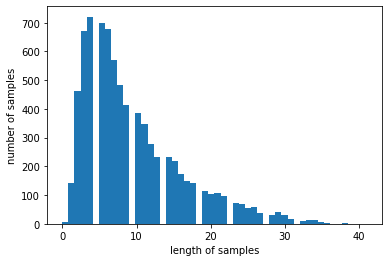

In [ ]:
print('트레인 셋의 데이터 갯수 :', len(sequences))
print('문장의 최대 길이 :', max(len(l) for l in sequences))
#print('문장의 평균 길이 :',sum(map(len, sequences))/len(sequences))
print('문장의 평균 길이 :', sum(len(i) for i in sequences) / len(sequences))
plt.hist([len(s) for s in sequences], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
max_len = 82
intent_train = pad_sequences(sequences, maxlen = max_len)
label_train = to_categorical(np.asarray(train_labels))
print('전체 데이터의 크기(shape):', intent_train.shape)
print('레이블 데이터의 크기(shape):', label_train.shape)

전체 데이터의 크기(shape): (7896, 82)
레이블 데이터의 크기(shape): (7896, 3)


In [ ]:
print(train_texts[19]) #원문
print(len(intent_train[19])) #길이
print(intent_train[19]) #토크나이즈, 인덱싱, 패딩 된 문장
print(label_train[19]) #인덱싱 된 라벨 (악플, 공격적, 평문)

180이하 호빗 한남들은 결혼 하지마셈 ㅋ 돈없으면 연애도 하지마셈 ㅋ 니들 호빗 유전자 받아서 고통받을 네 후손은 뭔죄임?
82
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 3443 1932  282 4367  372   11    8   93    2   16  147 1274  108
  103   34   84  379   12    2   16  147 1274  108  326  282 4367 2500
  157   85 1765  157   19   22 3445    8  177  319  131   18]
[1. 0. 0.]



<h3> 패딩 길이 30 </h3>

문장의 길이가 30보다 작거나 같은 문장 수 : 6094


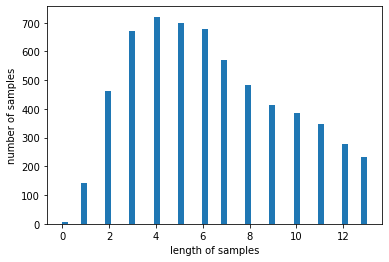

In [ ]:
print('문장의 길이가 13보다 작거나 같은 문장 수 :', sum(1 for l in sequences if len(l) <= 13))
plt.hist([len(s) for s in sequences if len(s)<=13], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
max_len = 13
filtered_idx = []
for l in sequences:
  if len(l) <= 13:
    filtered_idx.append(sequences.index(l))
print('필터링된 인덱스 갯수:', len(filtered_idx))
print('필터링된 인덱스 10개만 출력 :', filtered_idx[:10])
print('원본 인덱스 0의 문장 :', sequences[0])

#학습 데이터 필터링
filtered_sequences = [sequences[idx] for idx in filtered_idx]
filtered_labels = [train_labels[idx] for idx in filtered_idx]
print(filtered_sequences[0])
print(filtered_labels[0])
print(train_texts[1])
print(train_labels[1])

print('---------------------')
intent_train = pad_sequences(filtered_sequences, max_len)
label_train = to_categorical(np.asarray(filtered_labels))
print('전체 데이터의 크기 :', intent_train.shape)
print('레이블 데이터의 크기 :', label_train.shape)

print(train_texts[1]) #원문
print(len(intent_train[0])) #길이
print(intent_train[0]) #토크나이즈, 인덱싱, 패딩 된 문장
print(label_train[1]) #인덱싱 된 라벨 (악플, 공격적, 평문)

필터링된 인덱스 갯수: 6094
필터링된 인덱스 10개만 출력 : [1, 3, 4, 5, 7, 8, 10, 11, 12, 13]
원본 인덱스 0의 문장 : [1681, 1247, 1963, 1682, 64, 2744, 799, 3503, 66, 1247, 310, 93, 54, 330, 586, 1683, 65]
[5003, 1078, 2251, 857, 800, 205, 205, 384, 2252, 11]
2
....한국적인 미인의 대표적인 분...너무나 곱고아름다운모습...그모습뒤의 슬픔을 미처 알지못했네요ㅠ
2
---------------------
전체 데이터의 크기 : (6094, 13)
레이블 데이터의 크기 : (6094, 3)
....한국적인 미인의 대표적인 분...너무나 곱고아름다운모습...그모습뒤의 슬픔을 미처 알지못했네요ㅠ
13
[   0    0    0 5003 1078 2251  857  800  205  205  384 2252   11]
[0. 0. 1.]


In [ ]:
label_train

array([[0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [ ]:
print([idx for idx in filtered_idx])

[1, 3, 4, 5, 7, 8, 10, 11, 12, 13, 14, 16, 17, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 34, 37, 38, 39, 40, 41, 42, 44, 45, 46, 47, 48, 49, 52, 53, 54, 55, 56, 58, 59, 61, 62, 63, 64, 66, 67, 68, 69, 70, 71, 72, 73, 74, 76, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 90, 91, 92, 93, 94, 95, 96, 98, 100, 101, 102, 104, 105, 106, 107, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 120, 121, 122, 123, 124, 125, 129, 130, 131, 133, 136, 138, 140, 141, 143, 144, 145, 146, 148, 149, 150, 151, 152, 154, 155, 157, 158, 159, 160, 161, 162, 164, 166, 167, 168, 170, 171, 172, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 191, 192, 193, 194, 195, 196, 197, 198, 200, 201, 202, 203, 205, 206, 207, 208, 209, 210, 211, 212, 213, 216, 217, 220, 224, 225, 226, 227, 228, 229, 230, 231, 232, 234, 235, 236, 237, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 251, 252, 253, 254, 255, 259, 261, 262, 263, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276

<h3> 패딩 길이 40</h3>

문장의 길이가 40보다 작거나 같은 문장 수 : 6864


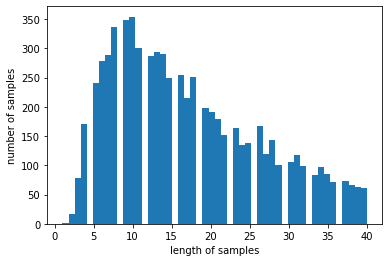

In [ ]:
print('문장의 길이가 40보다 작거나 같은 문장 수 :', sum(1 for l in sequences if len(l) <= 40))
plt.hist([len(s) for s in sequences if len(s)<= 40], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

<h2>테스트 데이터도 같은 패딩으로 길이 조절</h2>

In [ ]:
sequences2 = tokenizer.texts_to_sequences(tokenized_test)

In [ ]:
sequences2[0]

[105, 394, 143, 2, 3282, 2690, 8]

In [ ]:
print('테스트 문장의 최대길이 :',  max(len(i) for i in sequences2))
print('테스트 문장의 평균길이 :', sum(len(i) for i in sequences2) / len(sequences2))
#테스트 문장의 최대 길이도 82보다 작으므로 82에 패딩을 맞춘다.
print('전체 문장 수 :', len(sequences2))
print('문장의 길이가 10보다 작거나 같은 문장 수 :', sum(1 for l in sequences2 if len(l) <= 10))
print('문장의 길이가 20보다 작거나 같은 문장 수 :', sum(1 for l in sequences2 if len(l) <= 20))
print('문장의 길이가 30보다 작거나 같은 문장 수 :', sum(1 for l in sequences2 if len(l) <= 30))
print('문장의 길이가 40보다 작거나 같은 문장 수 :', sum(1 for l in sequences2 if len(l) <= 40))

'''intent_test = pad_sequences(sequences2, maxlen = max_len)
label_test = to_categorical(np.asarray(test_labels))
print('테스트 데이터의 크기(shape) : ', intent_test.shape)
print('테스트 라벨 크기(shape) : ', label_test.shape)'''

테스트 문장의 최대길이 : 35
테스트 문장의 평균길이 : 8.817409766454352
전체 문장 수 : 471
문장의 길이가 10보다 작거나 같은 문장 수 : 324
문장의 길이가 20보다 작거나 같은 문장 수 : 444
문장의 길이가 30보다 작거나 같은 문장 수 : 470
문장의 길이가 40보다 작거나 같은 문장 수 : 471


"intent_test = pad_sequences(sequences2, maxlen = max_len)\nlabel_test = to_categorical(np.asarray(test_labels))\nprint('테스트 데이터의 크기(shape) : ', intent_test.shape)\nprint('테스트 라벨 크기(shape) : ', label_test.shape)"

In [ ]:
max_len = 13
filtered_idx2 = []
for l in sequences2:
  if len(l) <= 13:
    filtered_idx2.append(sequences2.index(l))
print('필터링된 인덱스 갯수:', len(filtered_idx2))
print('필터링된 인덱스 10개만 출력 :', filtered_idx2[:10])
print('인덱스 0의 문장 :', sequences2[0])

#학습 데이터 필터링
filtered_sequences2 = [sequences2[idx] for idx in filtered_idx2]
filtered_labels2 = [test_labels[idx] for idx in filtered_idx2]
print(filtered_sequences2[0])
print(filtered_labels2[0])
print(test_texts[0])

print('---------------------')
intent_test = pad_sequences(filtered_sequences2, max_len)
label_test = to_categorical(np.asarray(filtered_labels2))
print('전체 데이터의 크기 :', intent_test.shape)
print('레이블 데이터의 크기 :', label_test.shape)

print(test_texts[0]) #원문
print(len(intent_test[0])) #길이
print(intent_test[0]) #토크나이즈, 인덱싱, 패딩 된 문장
print(label_test[0]) #인덱싱 된 라벨 (악플, 공격적, 평문)

필터링된 인덱스 갯수: 372
필터링된 인덱스 10개만 출력 : [0, 1, 3, 4, 5, 7, 8, 11, 12, 13]
인덱스 0의 문장 : [105, 394, 143, 2, 3282, 2690, 8]
[105, 394, 143, 2, 3282, 2690, 8]
2
송중기 시대극은 믿고본다. 첫회 신선하고 좋았다.
---------------------
전체 데이터의 크기 : (372, 13)
레이블 데이터의 크기 : (372, 3)
송중기 시대극은 믿고본다. 첫회 신선하고 좋았다.
13
[   0    0    0    0    0    0  105  394  143    2 3282 2690    8]
[0. 0. 1.]


In [ ]:
#검증 데이터 셋의 크기는 트레인의 10프로
val_idx = int(len(label_train)/10)
print(val_idx)

609


In [ ]:
#전처리 완료
x_train =  intent_train[:-val_idx]
y_train = label_train[:-val_idx]
x_val = intent_train[-val_idx:]
y_val = label_train[-val_idx:]
x_test = intent_test
y_test = label_test

In [ ]:
vocab_size

9094

In [ ]:
#임베딩 레이어 생성
w2v_model['죽이'].shape #w2v 모델의 차원이 200차원이다. 우리의 단어를 w2v 임베딩 하는 임베딩 레이어 투과

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


(200,)

In [ ]:
embedding_dim = 200
embedding_matrix = np.zeros([vocab_size,embedding_dim])

In [ ]:
embedding_matrix.shape

(9094, 200)

In [ ]:
def get_vector(word):
  if word in w2v_model:
    return w2v_model[word]
  else:
    return None

In [ ]:
for word,idx in word_index.items():
  a = get_vector(word)
  if a is not None:
    embedding_matrix[idx] = a

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
#모델 제작.
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, Dropout, Conv1D, GlobalMaxPooling1D, Dense, Input, Flatten, Concatenate

In [ ]:
#하이퍼 파라미터 
h = [3,4,5]
num_featuremaps = 200
drop_rate = 0.8

In [ ]:
#인풋 길이 13, 아웃풋 3개 
concate_list = []

model_input = Input((max_len,)) #인풋 레이어 설정
layer = Embedding(vocab_size, embedding_dim, weights = [embedding_matrix], trainable = False)(model_input) #여기서 trainable이 true라면 논문의 non-static

for hk in h:  #h가 3 (윈도우 3*embedding_dim),4,5일때 각각 피쳐맵, 맥스풀링
  conv = Conv1D(filters = num_featuremaps, kernel_size = hk, strides=1, padding='valid')(layer)
  conv = GlobalMaxPooling1D()(conv)
  #conv = Flatten()(conv)
  concate_list.append(conv)

layer = Concatenate()(concate_list) if len(concate_list) > 1 else concate_list[0]
layer = Dropout(drop_rate)(layer)
model_output = Dense(len(label_train[0]), activation = 'softmax')(layer)

model = Model(model_input, model_output)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics =['acc'])

model.summary()

# 11개 10개 9개의 피쳐맵을 각 200개씩 생성 why? 13-3+1, 13-4+1, 13-5+1개



# 80개 79개 78개 로 이루어진 피쳐맵을 각 100개씩 생성 why? 82-3+1개, 82-4+1개...



Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 13)]         0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 13, 200)      1818800     input_6[0][0]                    
__________________________________________________________________________________________________
conv1d_15 (Conv1D)              (None, 11, 200)      120200      embedding_5[0][0]                
__________________________________________________________________________________________________
conv1d_16 (Conv1D)              (None, 10, 200)      160200      embedding_5[0][0]                
____________________________________________________________________________________________

In [ ]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
%matplotlib inline

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [ ]:
history = model.fit(x_train, y_train, batch_size= 100, epochs = 15, validation_data=(x_val, y_val) )

Epoch 1/15
55/55 [==============================] - 4s 60ms/step - loss: 2.6642 - acc: 0.4049 - val_loss: 1.1338 - val_acc: 0.5304
Epoch 2/15
55/55 [==============================] - 3s 55ms/step - loss: 1.7168 - acc: 0.4892 - val_loss: 1.0400 - val_acc: 0.5287
Epoch 3/15
55/55 [==============================] - 3s 57ms/step - loss: 1.2254 - acc: 0.5491 - val_loss: 1.0037 - val_acc: 0.5287
Epoch 4/15
55/55 [==============================] - 3s 59ms/step - loss: 1.0020 - acc: 0.5887 - val_loss: 0.9747 - val_acc: 0.5452
Epoch 5/15
55/55 [==============================] - 3s 63ms/step - loss: 0.8760 - acc: 0.6250 - val_loss: 0.9603 - val_acc: 0.5402
Epoch 6/15
55/55 [==============================] - 3s 57ms/step - loss: 0.7927 - acc: 0.6622 - val_loss: 0.9688 - val_acc: 0.5337
Epoch 7/15
55/55 [==============================] - 3s 57ms/step - loss: 0.7247 - acc: 0.6888 - val_loss: 0.9542 - val_acc: 0.5419
Epoch 8/15
55/55 [==============================] - 3s 56ms/step - loss: 0.6663 - a

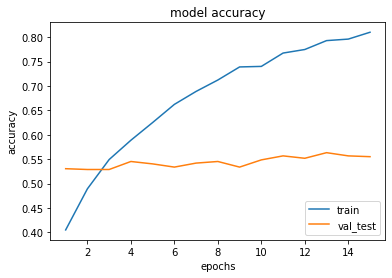

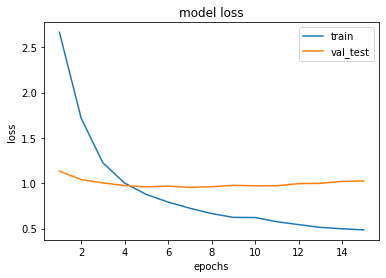

In [ ]:
epochs = range(1, len(history.history['acc']) + 1)
plt.plot(epochs, history.history['acc'])
plt.plot(epochs, history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'val_test'], loc='lower right')
plt.show()

epochs = range(1, len(history.history['loss']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'val_test'], loc='upper right')
plt.show()

In [ ]:
y_predicted = model.predict(x_test)
y_predicted = y_predicted.argmax(axis=-1)

In [ ]:
y_predicted

array([2, 2, 2, 1, 0, 2, 2, 1, 2, 2, 1, 2, 2, 1, 2, 2, 2, 0, 1, 2, 2, 1,
       2, 1, 2, 2, 1, 2, 1, 1, 0, 0, 2, 0, 1, 2, 2, 0, 1, 2, 2, 2, 2, 1,
       2, 2, 0, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 1, 2, 1, 2, 2, 0, 1, 2, 0,
       2, 2, 1, 1, 2, 2, 2, 0, 2, 2, 2, 1, 2, 1, 1, 2, 0, 1, 0, 2, 0, 2,
       1, 2, 1, 0, 1, 2, 2, 1, 1, 2, 1, 1, 1, 2, 2, 2, 0, 2, 2, 1, 2, 1,
       2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 1, 1, 2, 1, 2, 1, 1, 2, 2, 2, 2, 2,
       1, 2, 2, 2, 1, 2, 1, 2, 2, 2, 1, 1, 2, 2, 0, 1, 2, 2, 0, 1, 0, 2,
       2, 2, 2, 2, 1, 1, 2, 0, 2, 2, 1, 2, 2, 0, 2, 1, 0, 1, 2, 0, 1, 1,
       2, 0, 1, 1, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2,
       1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 1, 2, 2, 2,
       1, 2, 1, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 0,
       0, 2, 2, 1, 2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 2, 1, 2, 1, 1, 0, 2, 1,
       2, 2, 2, 2, 1, 0, 1, 0, 1, 2, 0, 1, 1, 1, 2, 0, 2, 1, 2, 0, 2, 1,
       2, 0, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2,

In [ ]:
y_test[2]

array([1., 0., 0.], dtype=float32)

In [ ]:
count = 0
for i in range(len(y_predicted)):
  if y_predicted[i] == list(y_test[i]).index(1.0):
    count+=1
print('accuracy: ', count / len(y_predicted))

accuracy:  0.5053763440860215


In [ ]:
model.save('/content/drive/MyDrive/Model/Udong_1DCNN_UPGRADEV3_per50.h5')

<h2> 사용 </h2>

In [ ]:
#pip install konlpy
#pip install tensorflow

In [10]:
pip list | grep tensorflow

tensorflow                    2.5.0              
tensorflow-datasets           4.0.1              
tensorflow-estimator          2.5.0              
tensorflow-gcs-config         2.5.0              
tensorflow-hub                0.12.0             
tensorflow-metadata           1.0.0              
tensorflow-probability        0.12.1             


In [11]:
pip list | grep konlpy

konlpy                        0.5.2              


In [3]:
#불러오기 후 사용용도
import jpype
import json
from konlpy.tag import Kkma
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
model = load_model('/content/drive/MyDrive/Model/Udong_1DCNN_UPGRADEV3_per50.h5')
noun_kkm = ['NNP', 'NNG', 'OL', 'NP','VV', 'VA' ] #사용할 품사

tokenizer = Tokenizer()
with open('/content/drive/MyDrive/Model/Udong1DCNN_wordindex_UPGRADEV3.json') as json_file:
  word_index = json.load(json_file)
  tokenizer.word_index = word_index


def tokenizer_kkma_noun2(doc):
  jpype.attachThreadToJVM()
  token_doc = [ word[0] for word in kkma.pos(doc) if word[1] in noun_kkm ]
  return token_doc
kkma = Kkma()

In [4]:
test = "찌질이 루저야 꼴값떨지마"
test = tokenizer_kkma_noun2(test)
test = tokenizer.texts_to_sequences([test])
test = pad_sequences(test, maxlen=13)
result = model.predict(test)
print('각 항목당 확률 악플(0), 공격적(1), 일반(2) :', result)
a = list(result[0])
print(a.index(max(a)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: jpype._core.attachThreadToJVM is deprecated, use java.lang.Thread.attach instead


각 항목당 확률 악플(0), 공격적(1), 일반(2) : [[0.93095374 0.04195646 0.02708986]]
0


In [ ]:
test = "너무 좋아요!!"
test = tokenizer_kkma_noun2(test)
test = tokenizer.texts_to_sequences([test])
test = pad_sequences(test, maxlen=13)
result = model.predict(test)
print('각 항목당 확률 악플(0), 공격적(1), 일반(2) :', result)
a = list(result[0])
print(a.index(max(a)))

각 항목당 확률 악플(0), 공격적(1), 일반(2) : [[0.04485546 0.14455305 0.8105914 ]]
2


In [ ]:
test = "사랑해요 우동~~!"
test = tokenizer_kkma_noun2(test)
test = tokenizer.texts_to_sequences([test])
test = pad_sequences(test, maxlen=13)
result = model.predict(test)
print('각 항목당 확률 악플(0), 공격적(1), 일반(2) :', result)
a = list(result[0])
print(a.index(max(a)))

각 항목당 확률 악플(0), 공격적(1), 일반(2) : [[0.00155875 0.00514543 0.99329585]]
2


In [ ]:
test = "그 좀 나서지 마요"
test = tokenizer_kkma_noun2(test)
test = tokenizer.texts_to_sequences([test])
test = pad_sequences(test, maxlen=13)
result = model.predict(test)
print('각 항목당 확률 악플(0), 공격적(1), 일반(2) :', result)
a = list(result[0])
print(a.index(max(a)))

각 항목당 확률 악플(0), 공격적(1), 일반(2) : [[0.21617232 0.45777276 0.32605493]]
1


In [ ]:
test = "또 선넘는거 하려고한다.. 이놈의 냄비근성,, 그냥 잘짜여지고 맛있는 식단을 제공하면 될것을 가지고 뷔페를 차리고 있네 ㅋㅋㅋ \\
취사병들은,, 군인 아니냐? 메뉴가 많아질수록 취사병이 힘들어지는건 안봐도 뻔하다 ㅋㅋ \\
적당히해 진짜 보여주기식으로 있어보이고 그럴듯한거 가지고와서 이도저도 아니게 도입하지 말고..근본을 챙겨라 제발"
test = tokenizer_kkma_noun2(test)
test = tokenizer.texts_to_sequences([test])
test = pad_sequences(test, maxlen=13)
result = model.predict(test)
print('각 항목당 확률 악플(0), 공격적(1), 일반(2) :', result)
a = list(result[0])
print(a.index(max(a)))

각 항목당 확률 악플(0), 공격적(1), 일반(2) : [[0.20893964 0.56826943 0.22279094]]
1


In [ ]:
test = "저동상은 머지???? 놀랍네 놀라. .누가보면 독립운동 하다 돌아가신줄.. 기껏해야 둘중 하나 아닌가? \\
술몽창 먹고 실족사 vs 술몽창먹고 휘청할때 누군가 살인.. .둘중에 머가됬떤 추모 동영상을 새울일인가? 적당히들 해라 이 할일 없는 인간들아"
test = tokenizer_kkma_noun2(test)
test = tokenizer.texts_to_sequences([test])
test = pad_sequences(test, maxlen=13)
result = model.predict(test)
print('각 항목당 확률 악플(0), 공격적(1), 일반(2) :', result)
a = list(result[0])
print(a.index(max(a)))

각 항목당 확률 악플(0), 공격적(1), 일반(2) : [[0.02483241 0.5060132  0.46915433]]
1


In [ ]:
test = "10만원 줄게 백만원써라?????????????????????????????????국민을 그냥 IQ 30짜리 지렁이 수준으로 아는 문재앙과 민주당.ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ"
test = tokenizer_kkma_noun2(test)
test = tokenizer.texts_to_sequences([test])
test = pad_sequences(test, maxlen=13)
result = model.predict(test)
print('각 항목당 확률 악플(0), 공격적(1), 일반(2) :', result)
a = list(result[0])
print(a.index(max(a)))

각 항목당 확률 악플(0), 공격적(1), 일반(2) : [[0.6850827  0.2911058  0.02381148]]
0
